# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**План работы**

1. Предобработка данных
- изучение данных
- выявление проблем с данными и их устранение
- поиск дубликатов

2. Исследовательский анализ данных
- исследование взаимосвязей
- поиск важных инсайтов в данных

3. Прогнозирование
- подготовка данных для обучения моделей бинарной классификации
- обучение моделей, тестирование и подсчёт метрик качества

4. Анализ результатов и выводы

## 1. Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
import datetime
import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
import shap
import warnings
warnings.filterwarnings('ignore')

In [2]:
TEST_SIZE = 0.2
RANDOM_STATE = 80822

In [3]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [4]:
def data_research(data):
    """Функция для получения общей информации о датафрейме: info(), первые 5 строк, describe(), поиск дубликатов"""
    return (display(data.info()), 
            display(data.head()), 
            display(data.describe()), 
            display('Относительное количество дубликатов в датасете:', data.customerID.duplicated().mean()))

In [5]:
data_research(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


'Относительное количество дубликатов в датасете:'

0.0

(None, None, None, None)

В данных таблицы contract отсутствуют пропуски, но необходимо привести строковые значения столбцов BeginDate и EndDate к формату datetime, а TotalCharges к вещественному типу.

In [6]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y.%m.%d')

In [7]:
contract['EndDate'].loc[contract['EndDate']=='No'] = np.NaN

In [8]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y.%m.%d')

In [9]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [10]:
# проверка
contract.info()
display(contract.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


Теперь столбце EndDate имеются значения NaN, на которые мы заменили имевшиеся значения No (для актуальных договоров) для изменения типа данных на datetime. Этот столбец станет основой для целевого признака задачи прогнозирования оттока клиентов. Также есть NaN в столбце TotalCharges в связи с применением аргумента errors='coerce'.

In [11]:
data_research(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


'Относительное количество дубликатов в датасете:'

0.0

(None, None, None, None)

В таблице personal в данных отсутствуют пропуски.

In [12]:
data_research(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


'Относительное количество дубликатов в датасете:'

0.0

(None, None, None, None)

In [13]:
# проверка, все ли пользователи интернета имеются в таблице contract по customerID 
internet.query('customerID in @contract.customerID')['customerID'].count()

5517

В данных таблицы internet отсутствуют пропуски. Строк при это меньше, чем в таблице contract, тк не все клиенты пользуются интернет услугами.

In [14]:
data_research(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


'Относительное количество дубликатов в датасете:'

0.0

(None, None, None, None)

In [15]:
# проверка, все ли пользователи интернета имеются в таблице contract по customerID 
phone.query('customerID in @contract.customerID')['customerID'].count()

6361

В данных отсутствуют пропуски. Строк меньше, чем в таблице contract, тк не все клиенты пользовались услугами телефонии. 

In [16]:
# листы из датафреймов и их названий для удобства обращения к ним при подсчёте количества уникальных значений столбцов
df_list = [contract, personal, internet, phone]
df_list_name = ['contract', 'personal', 'internet', 'phone']

In [17]:
# подсчёт уникальных значений столбцов датафреймов
i = 0
for df in df_list:
    print(colored(f'Датафрейм {df_list_name[i]}:', 'red'))
    print()
    columns_list = list(df.columns)
    i+=1
    for column in columns_list:
        print(colored(f'Подсчёт уникальных значений столбца {column}:\n', 'blue'), df[column].value_counts())
        print()

Датафрейм contract:

Подсчёт уникальных значений столбца customerID:
 7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

Подсчёт уникальных значений столбца BeginDate:
 2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64

Подсчёт уникальных значений столбца EndDate:
 2019-11-01    485
2019-12-01    466
2020-01-01    460
2019-10-01    458
Name: EndDate, dtype: int64

Подсчёт уникальных значений столбца Type:
 Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Подсчёт уникальных значений столбца PaperlessBilling:
 Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

Подсчёт уникальны

### Вывод

Были изучены исходные данные и произведена их предобработка:
- изменены типы данных;
- проверено отсутствие дубликатов;
- определен целевой признак;
- **выявлено, что все клиенты, о которых имеются сведения о расторжении договора, расторгли его с октября 2019 по январь 2020 года. (что может быть связано с проводившейся ранее маркетинговой кампанией по привлечению новых пользователей или нововведениями в условиях обслуживания, которые могли не понравиться пользователям; предварительно можно сопоставить даты подписания договора и его расторжения)**

## 2. Исследовательский анализ данных

In [18]:
# создание столбца diff_days_for_target - количество дней от заключения до расторжения договора
# для получения столбца целевого признака target (0 - клиент остался, 1 - клиент ушёл)
contract['diff_days_for_target'] = contract['EndDate'] - contract['BeginDate']
contract['diff_days_for_target'] = contract['diff_days_for_target'].dt.days.fillna(0).astype(int)

In [19]:
def target_value(row):
    """Функция определения значения целевого признака"""
    col_value = row['diff_days_for_target']
    if col_value == 0:
        return 0
    else:
        return 1

In [20]:
# применение функции target_value для получения target
contract['target'] = contract.apply(target_value, axis=1)
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,diff_days_for_target,target
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61,1
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61,1


In [21]:
# дни действия договора до расторжения (значения 0 для оставшихся клиентов отфильтруем)
contract_days = contract['diff_days_for_target'].loc[contract['diff_days_for_target']!=0].value_counts().sort_index(ascending=True)
# количество клиентов по длительности контракта до разрыва сортировкой по возрастанию количества дней
contract_days

30      182
31      198
61      123
91       31
92       63
       ... 
2130      3
2132      4
2160      5
2161      1
2191      6
Name: diff_days_for_target, Length: 131, dtype: int64

In [22]:
# первые 10 значений contract_days сортировкой по количеству ушедших пользователей
contract_days.sort_values(ascending=False).head(10)

31     198
30     182
61     123
153     64
92      63
122     58
214     51
365     38
91      31
273     31
Name: diff_days_for_target, dtype: int64

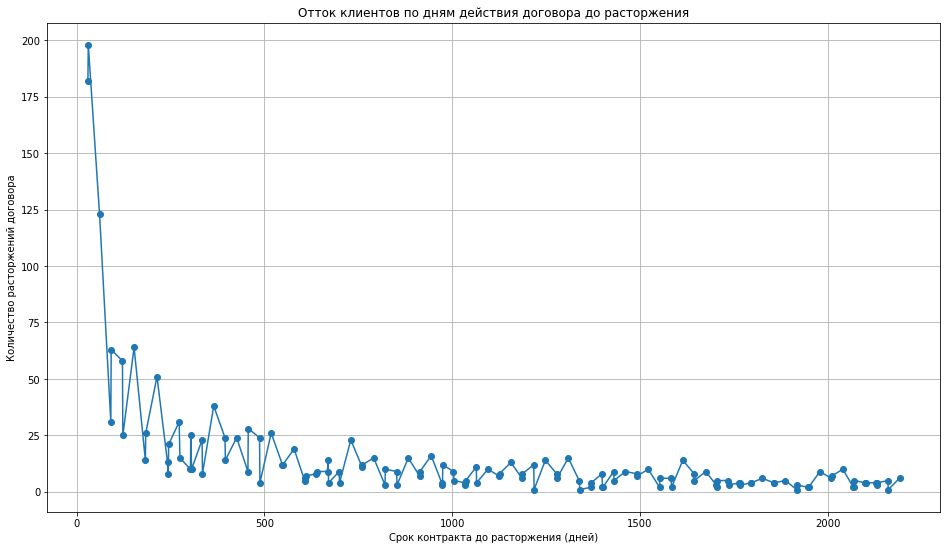

In [23]:
contract_days.plot(x='contract_days', figsize=(16,9), grid=True, marker='o')
plt.title('Отток клиентов по дням действия договора до расторжения')
plt.xlabel('Срок контракта до расторжения (дней)')
plt.ylabel('Количество расторжений договора')
plt.show()

В соответствии с условиями, существуют 3 опции заключения договора - на год, на два года и на месяц. Среди расторгнувших договор больше всего тех, кто заключил этот договор недавно. По графику выше и по contract_days видно, что в последнее время стали активно расторгать договора многие клиенты, для которых подходит срок их возможной пролонгации, в зависимости от условий Type (особенно недавно заключившие - 1-2 месяца).

In [24]:
# создание столбца diff - количество дней от заключения до расторжения договора или до текущей даты среза датафрейма (2020-02-01)
contract['diff'] = pd.to_datetime(contract['EndDate'].fillna('2020-02-01')) - contract['BeginDate']
contract['diff'] = contract['diff'].dt.days
# создание столбца diff_month - количество месяцев от заключения до расторжения договора или до текущей даты (2020-02-01)
contract['diff_month'] = round(contract['diff']/30).astype(int)
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,diff_days_for_target,target,diff,diff_month
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,31,1
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,0,1036,35
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61,1,61,2
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,0,1371,46
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61,1,61,2


In [25]:
# создание столбца со значением года, в котором был заключён контракт
contract['year'] = contract['BeginDate'].dt.year
# contract

In [26]:
# объединение датафреймов
df_merged = contract.merge(personal, on='customerID', how='left').merge(
    internet, on='customerID', how='left').merge(phone, on='customerID', how='left')
df_merged

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,diff_days_for_target,target,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,0,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61,1,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,0,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61,1,...,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1990.50,0,0,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7362.90,0,0,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,346.45,0,0,...,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,123,1,...,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [27]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customerID            7043 non-null   object        
 1   BeginDate             7043 non-null   datetime64[ns]
 2   EndDate               1869 non-null   datetime64[ns]
 3   Type                  7043 non-null   object        
 4   PaperlessBilling      7043 non-null   object        
 5   PaymentMethod         7043 non-null   object        
 6   MonthlyCharges        7043 non-null   float64       
 7   TotalCharges          7032 non-null   float64       
 8   diff_days_for_target  7043 non-null   int32         
 9   target                7043 non-null   int64         
 10  diff                  7043 non-null   int64         
 11  diff_month            7043 non-null   int32         
 12  year                  7043 non-null   int64         
 13  gender            

При объединении датафреймов в столбцах для клиентов, которые не пользовались соответствующими улсугами, появились пропущенные значения. Заполним их значениями 'No'.

In [28]:
column_list = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [29]:
for column in column_list:
    df_merged[column] = df_merged[column].fillna('No')

In [30]:
# # проверка
# df_merged.info()

In [31]:
# строки с неизвестными значениями TotalCharges
df_merged.loc[df_merged.TotalCharges.isna()==True]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,diff_days_for_target,target,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,0,0,...,No,Yes,No,No,No,No,No,No,No,No
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,0,0,...,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN,0,0,...,Yes,Yes,No,No,No,No,No,No,No,Yes
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN,0,0,...,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN,0,0,...,Yes,Yes,No,No,No,No,No,No,No,No
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN,0,0,...,Yes,Yes,No,No,No,No,No,No,No,Yes
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN,0,0,...,Yes,Yes,No,No,No,No,No,No,No,No
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN,0,0,...,Yes,Yes,No,No,No,No,No,No,No,No
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN,0,0,...,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


In [32]:
# замена NaN значений TotalCharges на 0
df_merged['TotalCharges'] = df_merged['TotalCharges'].fillna(0)
# df_merged['TotalCharges'] = df_merged['TotalCharges'].astype(float)

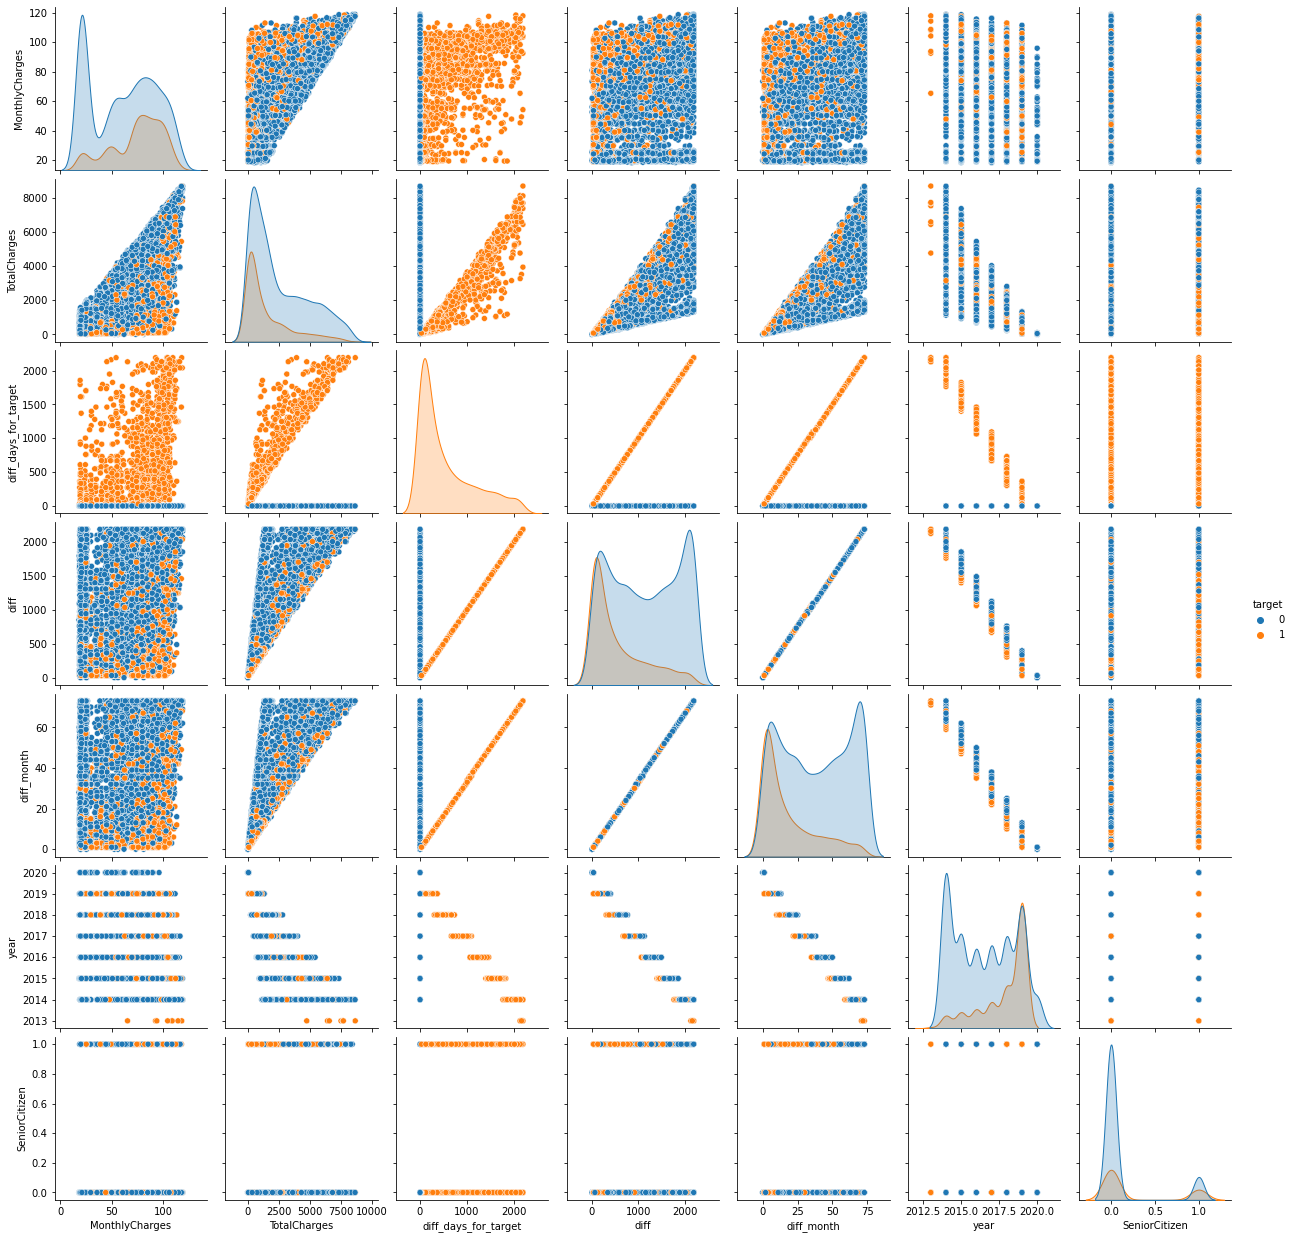

In [33]:
sns.pairplot(df_merged, hue='target');

Подтверждается, что большинство уходящих пользователей находились являлись клиентами короткий срок - 1-3 месяца.

Рассмотрим корреляции между данными датафрейма. С учётом имеющихся не только количественных, но и категориальных значений, воспользуемся 𝜙𝑘 -корреляцией.

Применим порядковое кодирование признаков.

In [34]:
encoder = OrdinalEncoder()
df_ordinal = pd.DataFrame(encoder.fit_transform(df_merged), columns = df_merged.columns)

In [35]:
phik_corr = df_ordinal.phik_matrix()
phik_corr.round(2)

interval columns not set, guessing: ['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'diff_days_for_target', 'target', 'diff', 'diff_month', 'year', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,diff_days_for_target,target,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,1.00,0.04,0.06,0.00,0.00,0.03,0.00,0.00,0.00,0.02,...,0.01,0.00,0.00,0.04,0.02,0.04,0.00,0.06,0.01,0.00
BeginDate,0.04,1.00,0.38,0.67,0.04,0.38,0.42,0.88,0.78,0.42,...,0.50,0.21,0.06,0.42,0.47,0.47,0.42,0.37,0.38,0.45
EndDate,0.06,0.38,1.00,0.36,0.16,0.21,0.30,0.30,0.67,1.00,...,0.12,0.13,0.29,0.14,0.07,0.05,0.13,0.05,0.05,0.03
Type,0.00,0.67,0.36,1.00,0.11,0.28,0.37,0.51,0.31,0.25,...,0.18,0.15,0.51,0.15,0.10,0.14,0.18,0.07,0.07,0.07
PaperlessBilling,0.00,0.04,0.16,0.11,1.00,0.37,0.46,0.20,0.21,0.30,...,0.01,0.17,0.23,0.00,0.20,0.16,0.06,0.34,0.33,0.25
PaymentMethod,0.03,0.38,0.21,0.28,0.37,1.00,0.39,0.37,0.21,0.45,...,0.24,0.22,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.34
MonthlyCharges,0.00,0.42,0.30,0.37,0.46,0.39,1.00,0.70,0.34,0.34,...,0.20,0.18,0.90,0.53,0.61,0.66,0.56,0.83,0.83,0.69
TotalCharges,0.00,0.88,0.30,0.51,0.20,0.37,0.70,1.00,0.60,0.33,...,0.44,0.14,0.50,0.54,0.66,0.67,0.56,0.66,0.67,0.62
diff_days_for_target,0.00,0.78,0.67,0.31,0.21,0.21,0.34,0.60,1.00,0.85,...,0.11,0.12,0.31,0.09,0.17,0.15,0.11,0.24,0.24,0.23
target,0.02,0.42,1.00,0.25,0.30,0.45,0.34,0.33,0.85,1.00,...,0.23,0.25,0.20,0.26,0.13,0.10,0.25,0.10,0.09,0.06


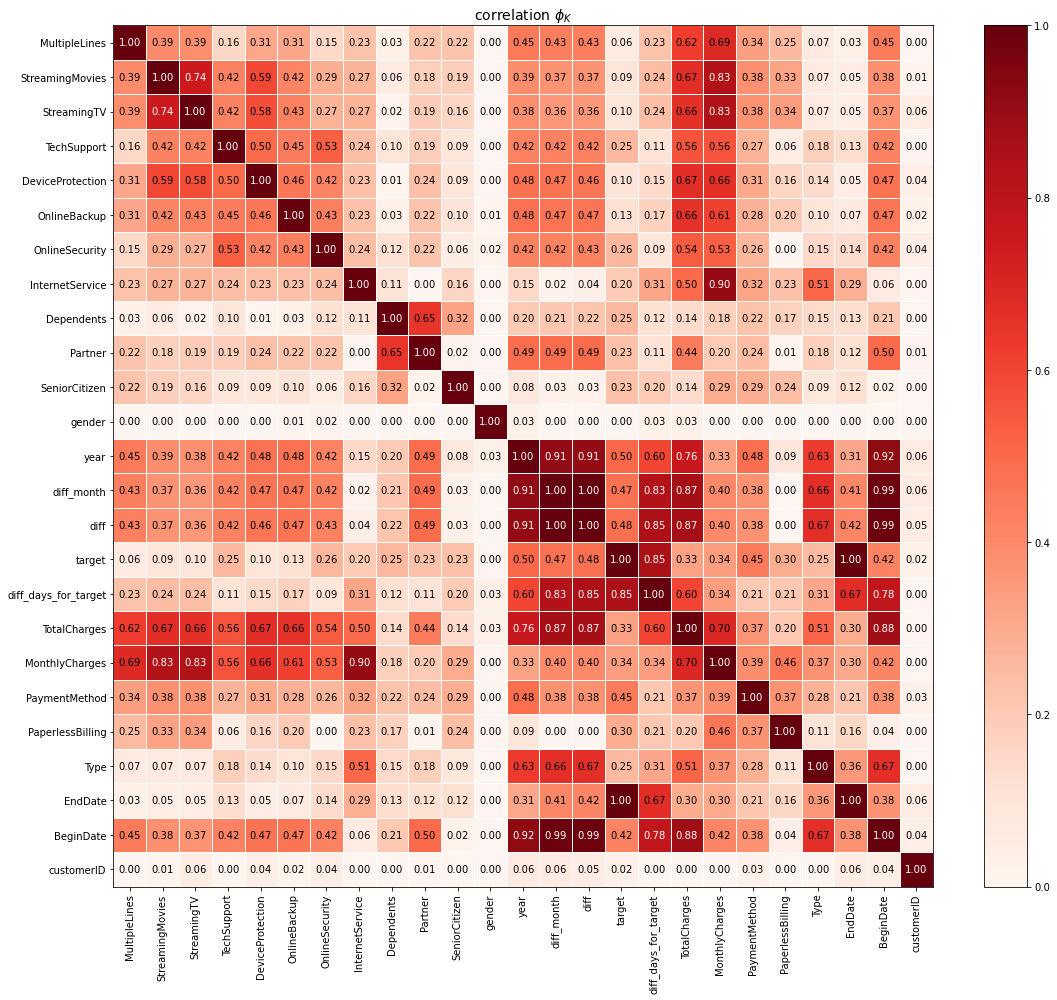

In [36]:
plot_correlation_matrix(phik_corr.values, 
                        x_labels=phik_corr.columns, 
                        y_labels=phik_corr.index, 
                        vmin=0, vmax=1, color_map="Reds", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(16, 14))
plt.tight_layout()

Удалим признаки с выявленной высокой корреляцией с целевым признаком и другими параметрами, а также временные признаки, сильно взаимозависимые с жизненным циклом клиента diff. Видно что столбец gender не коррелирует ни с одним из признаков в отличие от MonthlyCharges и TotalCharges, имеющих высокую зависимость с целым рядом параметров.

In [37]:
# подсчёт количества ушедших клиентов по признаку gender
df_merged['gender'].loc[df_merged['target']==1].value_counts()

Female    939
Male      930
Name: gender, dtype: int64

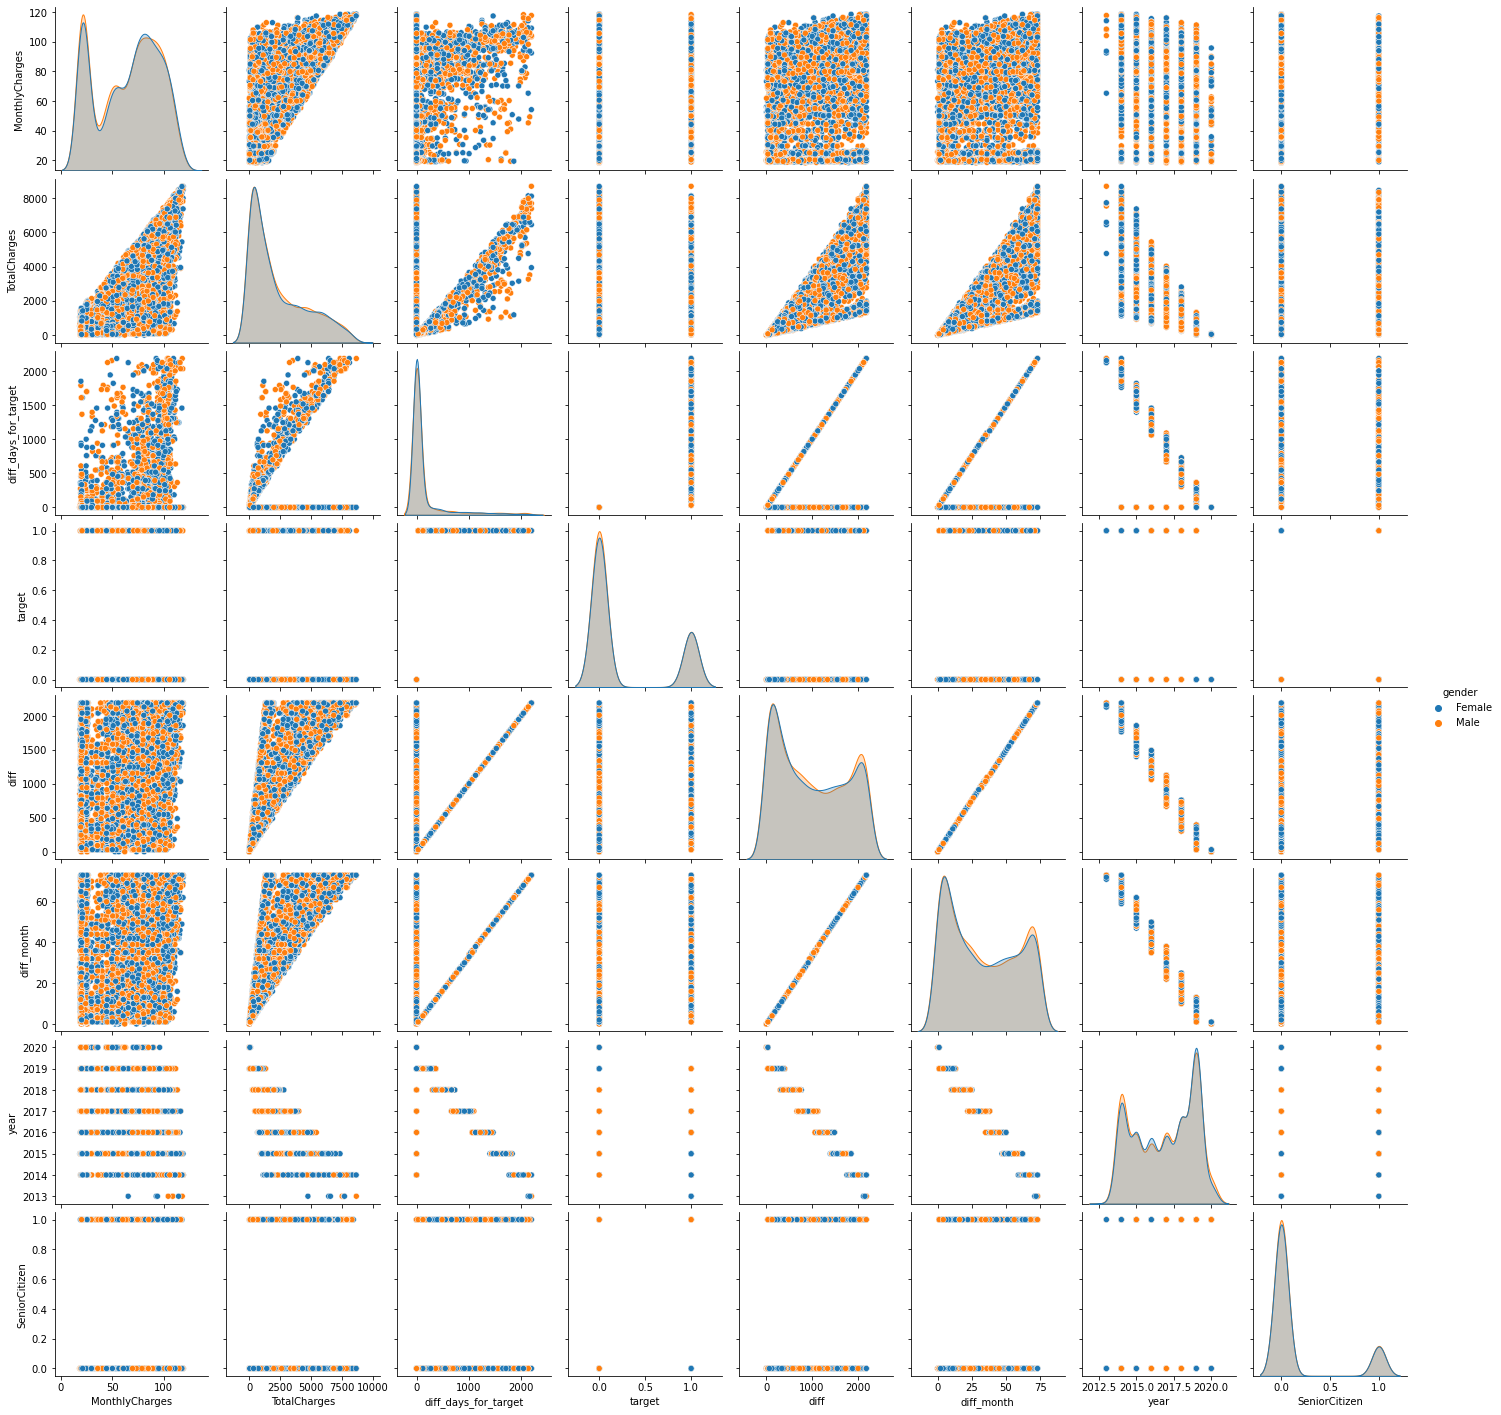

In [38]:
# визуализация распределения признака gender на парных диаграммах зависимостей свойств df_merged
sns.pairplot(df_merged, hue='gender');

Видно ,что распределение по половому признаку равномерное. Факт ухода клиента определяется другими параметрами. Рассмотрим статистическую значимость признаков.

In [39]:
df_merged = df_merged.drop(['customerID', 'BeginDate', 'EndDate', 'MonthlyCharges', 
                            'TotalCharges', 'diff_days_for_target', 'diff_month', 'year'], axis=1)

In [40]:
encoder = OrdinalEncoder()
df_ordinal = pd.DataFrame(encoder.fit_transform(df_merged), columns = df_merged.columns)

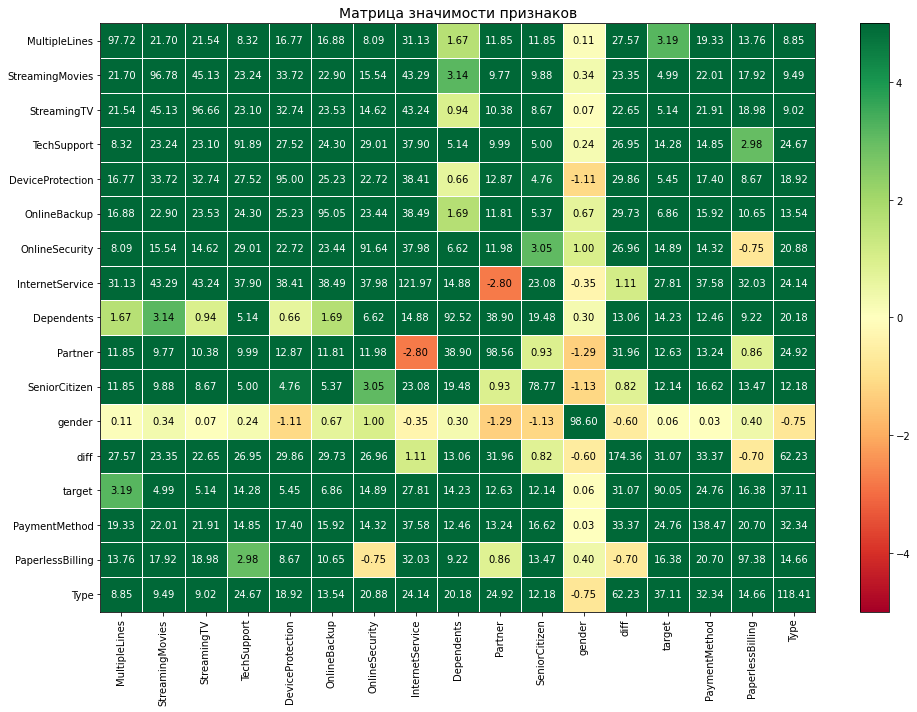

In [41]:
significance_overview = df_ordinal.significance_matrix(interval_cols=df_ordinal.columns)
plot_correlation_matrix(significance_overview.values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title='Матрица значимости признаков', 
                        usetex=False, fontsize_factor=1, figsize=(14, 10))
plt.tight_layout()

Рассмотрим дополнительно глобальную корреляцию.

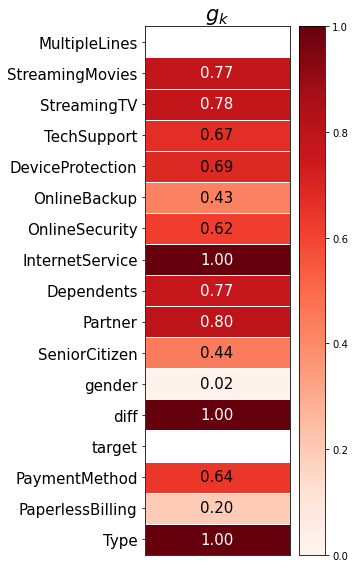

In [42]:
global_correlation, global_labels = df_ordinal.global_phik(interval_cols=df_ordinal.columns)

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(5,8),
                        color_map="Reds", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

Признак gender имеет низкую статистическую значимость, что подтверждается дополнительно низкой корреляцией на глобальной метрике.

In [43]:
df_merged = df_merged.drop(['gender'], axis=1)

In [44]:
# кодирование категориальных признаков
df_ohe = pd.get_dummies(df_merged, drop_first=True)

Month-to-month    1655
One year           166
Two year            48
Name: Type, dtype: int64

Yes    1400
No      469
Name: PaperlessBilling, dtype: int64

Electronic check             1071
Mailed check                  308
Bank transfer (automatic)     258
Credit card (automatic)       232
Name: PaymentMethod, dtype: int64

1    1869
Name: target, dtype: int64

0    1393
1     476
Name: SeniorCitizen, dtype: int64

No     1200
Yes     669
Name: Partner, dtype: int64

No     1543
Yes     326
Name: Dependents, dtype: int64

Fiber optic    1297
DSL             459
No              113
Name: InternetService, dtype: int64

No     1574
Yes     295
Name: OnlineSecurity, dtype: int64

No     1346
Yes     523
Name: OnlineBackup, dtype: int64

No     1324
Yes     545
Name: DeviceProtection, dtype: int64

No     1559
Yes     310
Name: TechSupport, dtype: int64

No     1055
Yes     814
Name: StreamingTV, dtype: int64

No     1051
Yes     818
Name: StreamingMovies, dtype: int64

No     1019
Yes     850
Name: MultipleLines, dtype: int64

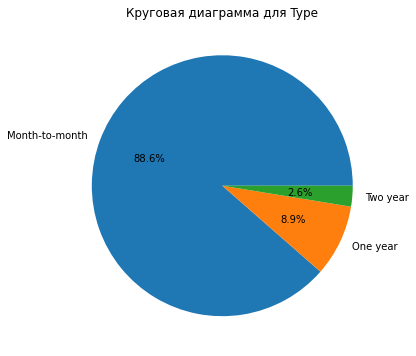

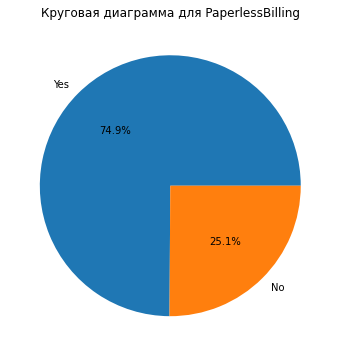

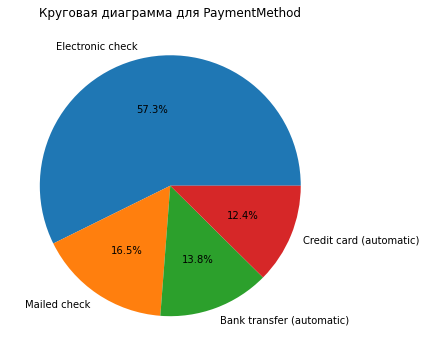

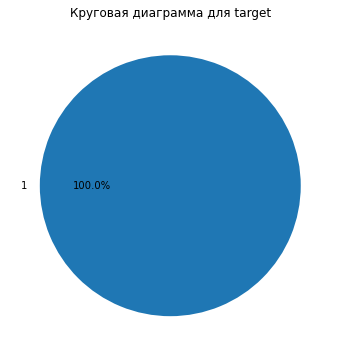

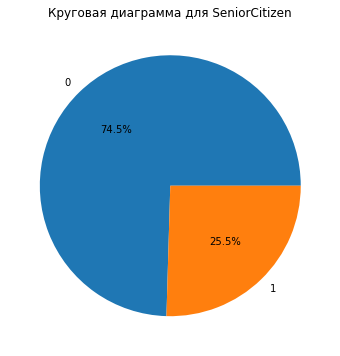

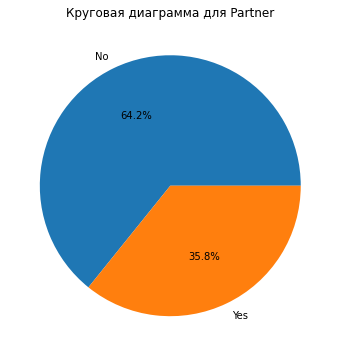

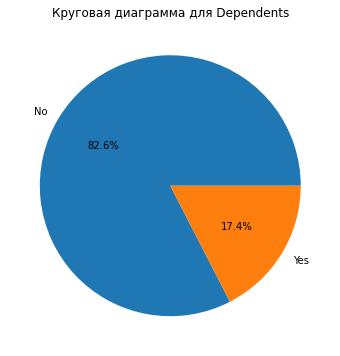

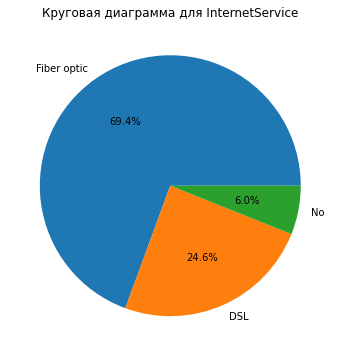

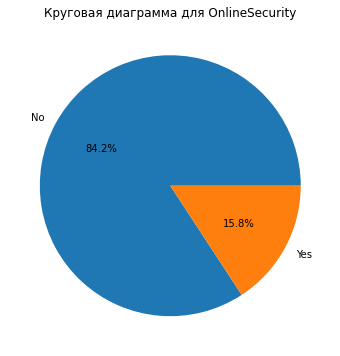

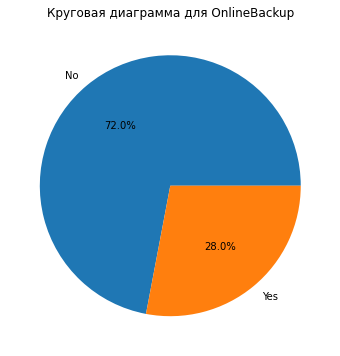

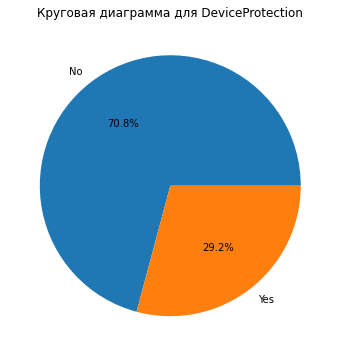

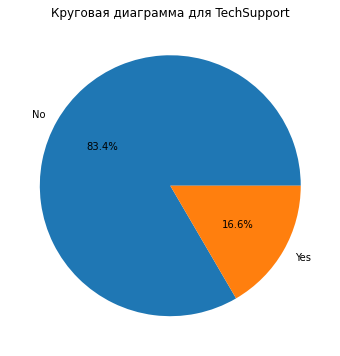

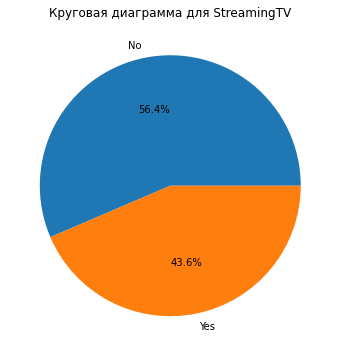

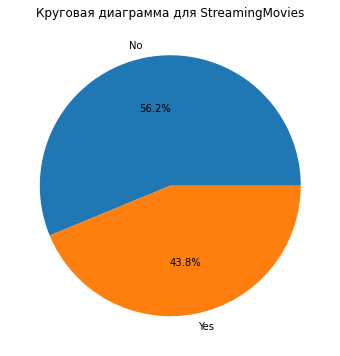

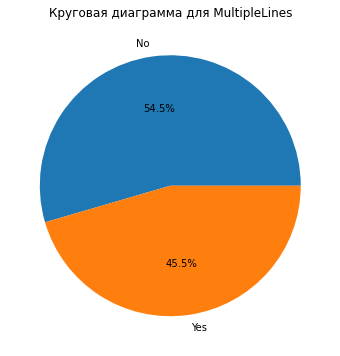

In [45]:
# определение количества ушедших пользователей по категориальным признакам
# col_feature_list = df_merged.columns.drop(['MonthlyCharges', 'TotalCharges', 'diff']).tolist()
col_feature_list = df_merged.columns.drop('diff').tolist()
for column in col_feature_list:
    df = df_merged[column].loc[df_merged['target']==1].value_counts()
    display(df)
    plt.figure(figsize=(9,6))
    plt.title(f'Круговая диаграмма для {column}')
    plt.pie(df, labels=df.index, autopct='%1.1f%%');

**Примерный портрет уходящих клиентов:**

- в 88% случаев являются обладателями краткосрочного договора (с ежемесячной пролонгацией)
- в 75% случаев не являются пенсионерами
- большинство не женаты/не замужем и в 83% случаев не имеют иждивенцев
- 94% являются пользователями интернета, большинство из которых не имели дополнительных опций, кроме StreamingTV и StreamingMovies (в 56% случаев)

### Вывод

Обнаруживаются корреляции между ежемесячным платежом и оптоволоконным подключением к интернету и обратная корреляция месячных платежей с отсутствием подключения к интернету. Таким образом, основную часть суммы платежей составляет стоимость подключения к интернету.

Также видны средние корреляции между платежами и наличием подключенных сервисов.

Можно увидеть среднюю корреляцию между пользователями на длительных двухгодовых контрактах с временем, в течение которого пользователи являются клиентами компании. При этом пользователей с долгосрочными контрактами чаще характеризует наличие партнера, иждивенцев и активация дополнительных сервисов.

Дополнительно можно заметить отсутствие влияния полового признака как на цель исследования, так и на все остальные признаки. Для задачи он не является значимым.

_______________________________________________________________________________________________________________________________

В соответствии с условиями, существуют 3 опции заключения договора - на год, на два года и на месяц. Среди расторгнувших договор больше всего тех, кто заключил этот договор недавно. В последнее время стали активно расторгать договора многие клиенты, для которых подходит срок их возможной пролонгации, в зависимости от условий Type (особенно недавно заключившие - 1-2 месяца).

_______________________________________________________________________________________________________________________________

**Примерный портрет уходящих клиентов:**

- в 89% случаев являются обладателями краткосрочного договора (с ежемесячной пролонгацией)
- в 72% случаев не являются пенсионерами
- большинство не женаты/не замужем и в 83% случаев не имеют иждивенцев
- 94% являются пользователями интернета, большинство из которых не имели дополнительных опций, кроме StreamingTV и StreamingMovies (в 56% случаев)

## Прогнозирование

### Подготовка признаков

In [46]:
# подготовка свойств и целевого признака
features = df_ohe.drop(['target'], axis=1)
target = df_ohe['target']

In [47]:
# разобьем исходный датасет на 2 выборки - обучающую и тестовую
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [48]:
# проверка
display(features_train.shape, features_test.shape)
display(target_train.shape, target_test.shape)

(5634, 19)

(1409, 19)

(5634,)

(1409,)

Масштабирование признаков

In [49]:
numeric = features.columns.tolist()
numeric

['diff',
 'SeniorCitizen',
 'Type_One year',
 'Type_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'Partner_Yes',
 'Dependents_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_Yes',
 'OnlineBackup_Yes',
 'DeviceProtection_Yes',
 'TechSupport_Yes',
 'StreamingTV_Yes',
 'StreamingMovies_Yes',
 'MultipleLines_Yes']

In [50]:
pd.options.mode.chained_assignment=None
# масштабирование численных признаков
scaler = StandardScaler()

features_train[numeric] = scaler.fit_transform(features_train[numeric])
# features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head()

,diff,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
1443,-1.200630,-0.434578,-0.510849,-0.563822,0.833328,-0.525456,-0.704003,1.823148,1.029911,-0.65792,-0.886418,-0.525731,-0.643826,-0.732683,1.380985,1.571373,-0.786744,-0.792966,-0.853669
6176,0.429236,-0.434578,-0.510849,-0.563822,0.833328,-0.525456,1.420449,-0.548502,-0.970958,-0.65792,1.128136,-0.525731,-0.643826,1.364846,-0.724121,-0.636386,-0.786744,-0.792966,1.171414
3107,1.610453,-0.434578,-0.510849,1.773611,0.833328,-0.525456,-0.704003,-0.548502,1.029911,-0.65792,1.128136,-0.525731,1.553215,1.364846,1.380985,1.571373,1.271062,1.261089,1.171414
730,0.509591,-0.434578,-0.510849,-0.563822,0.833328,-0.525456,1.420449,-0.548502,-0.970958,-0.65792,1.128136,-0.525731,-0.643826,-0.732683,1.380985,1.571373,-0.786744,-0.792966,1.171414
1558,-0.671627,-0.434578,-0.510849,-0.563822,0.833328,1.903108,-0.704003,-0.548502,-0.970958,-0.65792,1.128136,-0.525731,-0.643826,1.364846,1.380985,-0.636386,-0.786744,1.261089,1.171414


Посмотрим как распределены классы в целевом признаке:

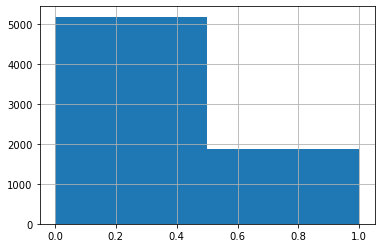

In [51]:
target.hist(bins=2);

Обнаружен дисбаланс классов целевого признака в соотношении примерно 1:3.

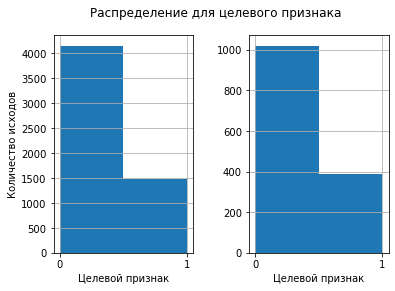

In [52]:
# построим гистограмму распределения значений (0 или 1) для выборок целевого признака
plt.suptitle('Распределение для целевого признака')
plt.subplots_adjust(wspace= .4)

plt.subplot(1, 2, 1)
target_train.hist(bins=2)
plt.xticks([0,1])
plt.xlabel('Целевой признак')
plt.ylabel('Количество исходов');

plt.subplot(1, 2, 2)
target_test.hist(bins=2)
plt.xticks([0,1])
plt.xlabel('Целевой признак');

Соотношение классов осталось таким же и в выборках. Учтём наличие дисбаланса классов при работе моделей.

### Обучение моделей

Для решения задачи бинарной классификации воспользуемся моделями RandomForestClassifier, LogisticRegression и CatBoostClassifier. Сравним работу baseline моделей с помощью валидационной выборки.

In [53]:
model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
model.fit(features_train, target_train)
scores = cross_val_score(estimator=model, X=features_train, y=target_train, cv=5)
rf_score = round(scores.mean(), 3)
print(scores)
print(f'Среднее значение cv_score: {rf_score}')

[0.78172138 0.8065661  0.78615794 0.8065661  0.81705151]
Среднее значение cv_score: 0.8


In [54]:
model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
model.fit(features_train, target_train)
scores = cross_val_score(estimator=model, X=features_train, y=target_train, cv=5)
lr_score = round(scores.mean(), 3)
print(scores)
print(f'Среднее значение cv_score: {lr_score}')

[0.74534161 0.73469388 0.75244011 0.7444543  0.75754885]
Среднее значение cv_score: 0.747


In [55]:
model = CatBoostClassifier(random_state=RANDOM_STATE, class_weights = (1, 3), verbose=False)
model.fit(features_train, target_train)
scores = cross_val_score(estimator=model, X=features_train, y=target_train, cv=5)
cb_score = round(scores.mean(), 3)
print(scores)
print(f'Среднее значение cv_score: {cb_score}')

[0.84117125 0.82786158 0.83229814 0.82697427 0.8321492 ]
Среднее значение cv_score: 0.832


**Вывод**

In [56]:
# датафрейм с результатами работы базовых моделей
baseline_result = pd.DataFrame({'model': ['RandomForestClassifier', 'LogisticRegression', 'CatBoostClassifier'], 
                               'cv_score': [rf_score, lr_score, cb_score]})
baseline_result

,model,cv_score
0,RandomForestClassifier,0.800
1,LogisticRegression,0.747
2,CatBoostClassifier,0.832


Лучшее значение метрики получили у CatBoostClassifier.

#### Подбор гиперпараметров

In [57]:
%%time
parameters = { 'n_estimators': range (100, 600, 100),
              'max_depth': range (4,20, 4) }
model_rfc = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
grid_rfc = GridSearchCV(model_rfc, parameters, scoring='roc_auc', cv=5)
grid_rfc.fit(features_train, target_train)

display(grid_rfc.best_params_)
grid_rfc.best_score_

{'max_depth': 8, 'n_estimators': 500}

Wall time: 1min 43s


0.8570919279433629

In [58]:
%%time
parameters = { 'max_iter': range (10, 100, 10),
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'C': [1, 10, 100, 1000] }
model_lr = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
grid_lr = GridSearchCV(model_lr, parameters, scoring='roc_auc', cv=5)
grid_lr.fit(features_train, target_train)

display(grid_lr.best_params_)
grid_lr.best_score_

{'C': 1000, 'max_iter': 10, 'solver': 'lbfgs'}

Wall time: 38.3 s


0.8412670713912835

In [59]:
%%time
parameters = {'depth': range (4, 8, 2),
              'l2_leaf_reg': [1, 3], 
              'n_estimators': range (1500, 2600, 500)}
model_cbc = CatBoostClassifier(random_state=RANDOM_STATE, class_weights = (1, 3), verbose=False)
grid_cbc = GridSearchCV(model_cbc, parameters, scoring='roc_auc')
grid_cbc.fit(features_train, target_train)

display(grid_cbc.best_params_)
grid_cbc.best_score_

{'depth': 4, 'l2_leaf_reg': 1, 'n_estimators': 2500}

Wall time: 7min 47s


0.9394087338271394

На тестировании будем использовать модель CatBoost с лучшими параметрами {'depth': 4, 'l2_leaf_reg': 1, 'n_estimators': 2500}.

#### Тестирование

In [60]:
grid_cbc.best_params_

{'depth': 4, 'l2_leaf_reg': 1, 'n_estimators': 2500}

In [61]:
def plot_roc_curve(model, features, target):
    """Функция для построения кривой ROC-кривой"""
    probabilities = model.predict_proba(features)
    probabilities_one = probabilities[:, 1]
    auc_roc = roc_auc_score(target, probabilities_one)
    # метрика AUC-ROC
    print('auc-roc :', auc_roc)
    
    fpr, tpr, thresholds = roc_curve(target, probabilities_one)
    # кривая AUC-ROC
    plt.figure()
    plt.plot(fpr, tpr)
    # ROC-кривая случайной модели
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

auc-roc : 0.9404141818273319


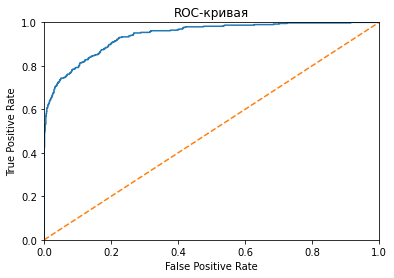

In [62]:
best_model = CatBoostClassifier(**grid_cbc.best_params_, random_state=RANDOM_STATE, class_weights = (1, 3), verbose=False)
best_model.fit(features_train, target_train)
predictions = best_model.predict(features_test)
plot_roc_curve(best_model, features_test, target_test)

### Вывод

Целевая метрика 0.75 была достигнута для всех исследуемых моделей.

Для лучшей модели CatBoostClassifier получен показатель метрики 0.94.

## Анализ результатов

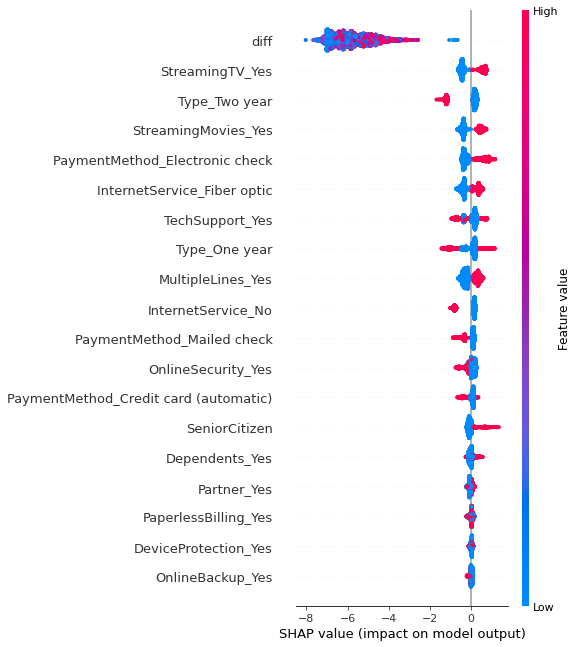

In [63]:
# важность признаков
shap_test = shap.TreeExplainer(best_model).shap_values(df_ohe.drop('target', axis=1))
shap.summary_plot(shap_test, df_ohe.drop('target', axis=1), max_display=25, auto_size_plot=True)

По итогам работы был составлен\
**Примерный портрет уходящих клиентов:**

- в 88% случаев являются обладателями краткосрочного договора (с ежемесячной пролонгацией)
- в 75% случаев не являются пенсионерами
- большинство не женаты/не замужем и в 83% случаев не имеют иждивенцев
- 94% являются пользователями интернета, большинство из которых не имели дополнительных опций, кроме StreamingTV и StreamingMovies (в 56% случаев)

- В соответствии с условиями, существуют 3 опции заключения договора - на год, на два года и на месяц. Среди расторгнувших договор больше всего тех, кто заключил этот договор недавно. В последнее время стали активно расторгать договора многие клиенты, для которых подходит срок их возможной пролонгации, в зависимости от условий Type (особенно недавно заключившие - 1-2 месяца).

- Таким образом, видно что расторгают договора преимущественно клиенты мобильной социальной группы. 
Как было выявлено ранее - все клиенты, о которых имеются сведения о расторжении договора, расторгли его с октября 2019 по январь 2020 года (текущий момент среза данных). Требует уточнения вопрос, были ли эти клиенты привлечены посредством маркетинговой кампании по привлечению новых пользоваталей, либо имело место изменение условий обслуживания (например, увеличение абонентской платы), либо же на рынке появился конкурент, который предлагает пользователям более выгодные условия.

- В связи с риском продолжения оттока клиентов, рекомендуется продумать маркетинговую кампанию, направленную на составленный выше портрет уходящих пользователей, либо рассмотреть возможность изменения условий обслуживания.

- В ходе работы была построена модель CatBoostClassifier, прогнозирующая отток клиентов, для которой удалось добиться показателя точности 0.94.

## Отчёт

Задача определения оттока клиентов представляет собой задачу построения модели бинарной классификации.
Работа выполнена в соответствии с ранее определённым планом. Достигнуто целевое значение метрики AUC-ROC.

При выполнении задачи возникли сложности с работой с временными типами данных в части оптимальной их обработки, а также с методикой определения оптимальной для решения задачи модели.

- На этапе предобработки осуществлено ознакомление с данными имеющихся датасетов и подготовка их к исследованию - поиск возможных аномалий, дубликатов, пропусков, замена типов данных.
- В процессе исследования данных был определён целевой признак, объединены датафреймы, исследованы взаимосвязи в данных и исключены признаки, которые могли бы дать утечку при предсказании целевого показателя, - столбцы с датами подписания и разрыва договора; а также идентификатор клиента тк он для каждого уникален и не несёт никакой информации для исследования. Добавлен столбец diff - жизненный цикл клиента. Удалены 11 строк, в которых в столбце TotalCharges были NaN'ы.  Дополнительно выявлена хронологическая закономерность оттока клиентов и составлен портрет уходящего пользователя по имеющимся взаимосвязям данных с целевым признаком.
- При подготовке данных к работе моделей для кодирования категориальных признаков был применён метод OHE с удалением столбца drop_first=True с целью избежать ловушки фиктивных признаков. После разбиения датасета на свойства и целевой признак, в целевом признаке был обнаружен дисбаланс классов, в соотношении примерно 3:1, учтённый позже в работе моделей. Лучшая модель была выбрана методом кросс-валидации, итоговую метрику AUC-ROC которой при тестировании её работы удалось улучшить подбором гиперпараметров через GridSearchCV.

По итогам работы лучший результат был получен у модели CatBoostClassifier с параметрами:
- глубина дерева: 4
- коэффициент регуляризации: 1
- максимальное количество деревьев: 2500

**Достигнуто значение метрики auc-roc: 0.94**